In [2]:
###########################
# LOADING EVDEV LIBRARIES #
###########################
import asyncio
import evdev
from evdev import list_devices, InputDevice, InputEvent, categorize, ecodes, UInput
import evdev

import pyautogui

##################################
# LOADING              LIBRARIES #
##################################


import threading
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import mss
import sched, time
import cv2
import pickle
from multiprocessing import Process, Manager
from multiprocessing.managers import BaseManager
import subprocess
import os, sys

##################################
# LOADING DEEPLEARNING LIBRARIES #
##################################
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

##################################
# LOADING FUNCTIONS & CLASSES    #
##################################


class CircularQueue(object):
    #Constructor
    def __init__(self,maxSize=3):
        self.queue = list()
        self.head = 0
        self.maxSize = maxSize
    #Adding elements to the queue
    def enqueue(self,data):
        if len(self.queue) >= self.maxSize:
            self.queue.pop(0)
            self.queue.append(data)
        else:
            self.queue.append(data)
        return True
    def return_queue(self):
        return self.queue

def save_to_file(objeto, nome_arquivo):
    with open(nome_arquivo, 'wb') as output:
        pickle.dump(objeto, output, pickle.HIGHEST_PROTOCOL)


def load_file(nome_arquivo):
    with open(nome_arquivo, 'rb') as input:
        objeto = pickle.load(input)
    return objeto

In [3]:
import re

In [4]:
x = re.search("^The.*Spain$", txt)

NameError: name 'txt' is not defined

In [ ]:
def generate_emulator_pid():

    p = subprocess.Popen(['gens','/home/ormenesse/Documents/Reinforced_Outrun/OutRun (USA, Europe).md'])
    
    # wait for the process to start
    time.sleep(0.15)

    # you gotta have xdotool installed in your machine

    output = subprocess.check_output(['xdotool','search','--pid',str(p.pid)])
    xw_id = str(output).split('\\n')[1]
    output = subprocess.run(['xwininfo','-id',xw_id],stdout=subprocess.PIPE)
    output = output.stdout.decode('utf-8')
    
    print(output)
    
    #get screens positions

    upperleftx = int(re.findall('Absolute upper-left X:  (\d+)',txt)[0])#int(output.split('\n')[3][-4:])
    upperlefty = int(re.findall('Absolute upper-left Y:  (\d+)',txt)[0])#int(output.split('\n')[4][-4:])

    # load quick save state
    
    pyautogui.press('f8')

    return p, upperleftx, upperlefty

def kill_process(p):

    p.kill()

def capture(graber,queue,positionx,positiony):
    i = 0
    while i != 3:
    #print("Comecando a gavar...")
        sct_img = graber.grab({'left': positionx, 'top': positiony+40, 'width': 640, 'height': 446})
        Img = Image.frombytes('RGB', sct_img.size, sct_img.bgra, 'raw', 'BGRX')
        Img.thumbnail((320,220), Image.ANTIALIAS)
        Img = np.array(Img.convert('L')).astype(np.uint8)
        #Img = Img.T
        queue.enqueue(Img)
        i = i +1
        time.sleep(0.15)

In [5]:
imgs = load_file('fila_treino.pkl')

In [6]:
len(imgs)

260

In [14]:
imgs[250][0].shape

(220, 320)

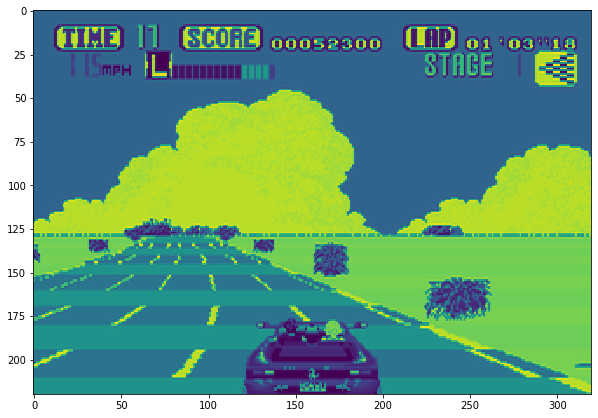

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(imgs[250][0])

In [20]:
imgs[249][2]

51600

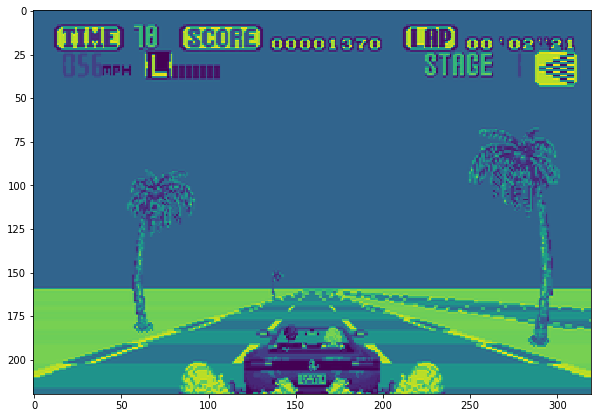

In [128]:
plt.figure(figsize=(10,10))
plt.imshow(imgs[17][0][2])

In [133]:
#generate score model
def generate_scoring_model():
    
    model = tf.keras.models.load_model('../OCR_MODEL_OUTRUN/'+'modelo_captcha_outrun')
    
    return model

# transforming vector to numbers.
def vec_to_captcha(vec):
    text = []
    captcha_word = "0123456789"
    vec[vec < 0.5] = 0
    
    captcha_word = "0123456789"

    word_len = 8
    word_class = len(captcha_word)
    
    char_pos = vec.nonzero()[0]
    
    for i, ch in enumerate(char_pos):
        text.append(captcha_word[ch % word_class])
        
    return ''.join(text)

def return_only_numbers(i):
    return np.expand_dims(np.array(i[14:25,135:201]).astype(np.float), axis=-1)

def return_score(image,model):
    try:
        print(vec_to_captcha(model.predict(np.expand_dims(return_only_numbers(image),axis=0))[0]))
        return int(vec_to_captcha(model.predict(np.expand_dims(return_only_numbers(image),axis=0))[0]))
    except:
        return -1

In [112]:
score_model = generate_scoring_model()

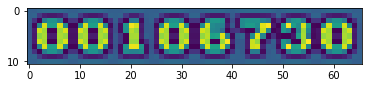

In [132]:
plt.imshow(np.array((imgs[360][0][2]))[14:25,135:201])

In [134]:
return_score(imgs[360][0][2],score_model)

001630


1630

In [135]:
import cv2, pytesseract

In [136]:
def return_result(img):
    res = cv2.resize(img[14:25,135:201], dsize=(4*img[14:25,135:201].shape[1],4*img[14:25,135:201].shape[0]), interpolation=cv2.INTER_CUBIC)
    rest = pytesseract.image_to_string(cv2.blur(res,(5,5)),nice=1,config='--psm 7 --oem 3 digits')
    print(rest)

In [137]:
return_result(imgs[360][0][2])

00106730


In [197]:
##################################
#         DECISION MODEL         #
##################################

# action model
def generate_model():
    input_shape = (220, 320,3)
    num_classes = 14
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Lambda(lambda x: x/255,input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    #model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    model.add(tf.keras.layers.Dense(num_classes))
    
    return model

def get_controler_action(predict):
    
    # plausible positions I got when gaming
    # 100000*comandos['acelera']+10000*comandos['freia']+1000*comandos['direita']+100*comandos['esquerda']+10*comandos['cima']+comandos['baixo']
    comands = [     0,    100,   1000,  10100,  11000, 100000, 100001, 100010, 100100, 101000, 101001, 101010, 110100, 111000]
    
    argument = predict.argmax()
    
    cmd_number = comands[argument]
    
    if cmd_number == 0:
        
        return [0, 0, 0, 0, 0, 0]
    
    else:
        
        baixo = cmd_number // 10**1 % 10
        
        cima = cmd_number // 10**2 % 10
        
        esquerda = cmd_number // 10**3 % 10
        
        direita = cmd_number // 10**4 % 10
        
        freia = cmd_number // 10**5 % 10
        
        acelera = cmd_number // 10**6 % 10
        
        return [acelera, freia, direita, esquerda, cima, baixo]
    
def capture_return_decision(images,model): 
    
    # predict command
    imgs = np.array(images).astype(np.uint8)
    imgs = np.expand_dims(imgs, axis=0)
    imgs = np.swapaxes(imgs,1,2)
    imgs = np.swapaxes(imgs,2,3)
    
    return model.predict(imgs), imgs

In [198]:
model = generate_model()
#pre trained model
model.load_weights('/home/ormenesse/Documents/Reinforced_Outrun/Action_Encoded_Model/modelo_outrun_encoded_learning_best_mse.hdf5')

In [199]:
b, entrada = capture_return_decision(imgs[10][0],model)

In [200]:
b.argmax()

0

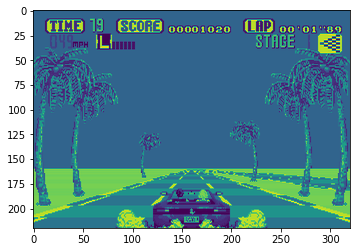

In [201]:
plt.imshow(entrada[0,:,:,0])